# Lab 3: Face Detection in Noise with Human and Machine Comparison


In this lab, you'll explore how the detectability of faces changes as they are blended with varying amounts of Gaussian noise. You will make behavioral measurements to estimate your **Point of Subjective Equality (PSE)** for face detection and compare your performance to a machine vision model.

This experiment is inspired by studies of **pareidolia** and visual inference, and links human perceptual performance with that of modern **deep neural networks** trained for face detection.


In [1]:
# Install required packages 
!pip install opencv-python 

  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (67.0 MB)


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.datasets import fetch_lfw_people
from IPython.display import display, clear_output
import random
from datetime import datetime
import os
from PIL import Image
import urllib.request
from collections import defaultdict
import time
from datetime import datetime

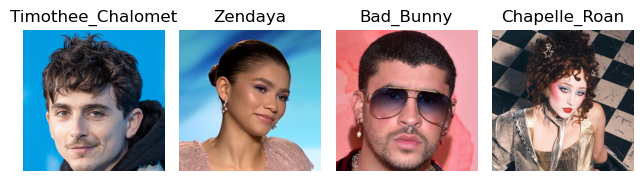

Loaded 4 faces, each of shape (256, 256, 3)


In [3]:
# Parameters
output_dir = "./faces"
output_data_path = '../expt_results/lab3/'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_data_path, exist_ok=True)
target_size = (256, 256)  # Width, Height

# Image sources
image_urls = {
    "Timothee_Chalomet": "https://upload.wikimedia.org/wikipedia/commons/thumb/5/5c/Timoth%C3%A9e_Chalamet-63482_%28cropped%29.jpg/1280px-Timoth%C3%A9e_Chalamet-63482_%28cropped%29.jpg",  # Timothee Chalomet (Wikipedia)
    "Zendaya": "https://upload.wikimedia.org/wikipedia/commons/3/3c/Zendaya_promoting_Smallfoot_for_MTV_international.png", # Zendaya (Wikipedia)
    "Bad_Bunny": "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/Bad_Bunny_2019_by_Glenn_Francis_%28cropped%29.jpg/1280px-Bad_Bunny_2019_by_Glenn_Francis_%28cropped%29.jpg",  # Bad Bunny with sunglasses (Wikipedia)
    "Chapelle_Roan": "https://static.wikia.nocookie.net/chappell-roan/images/b/b4/Chappell-Roan.jpg/revision/latest?cb=20241006152827"
}

# Helper: crop to square
def crop_center_square(pil_img):
    width, height = pil_img.size
    min_dim = min(width, height)
    left = (width - min_dim) // 2
    top =  (height - min_dim) // 10 # assumes face is near the top
    right = left + min_dim
    bottom = top + min_dim
    return pil_img.crop((left, top, right, bottom))

# Download, crop, resize, and store
face_images = []
labels = []
i = 1

for name, url in image_urls.items():
    filename = os.path.join(output_dir, f"{name}.jpg")
    urllib.request.urlretrieve(url, filename)

    # Open, crop, resize
    img = Image.open(filename).convert("RGB")
    img = crop_center_square(img)
    img = img.resize(target_size, Image.LANCZOS)

    # Store in array
    face_images.append(np.array(img))
    labels.append(name)

    # plot
    plt.subplot(1,len(image_urls), i)
    plt.imshow(np.array(img))
    plt.title(name)
    plt.axis("off")
    i+=1

plt.tight_layout()
plt.show()

# Final result as a NumPy array
faces_array = np.stack(face_images)  # Shape: (num_images, height, width, 3)

print(f"Loaded {faces_array.shape[0]} faces, each of shape {faces_array.shape[1:]}")


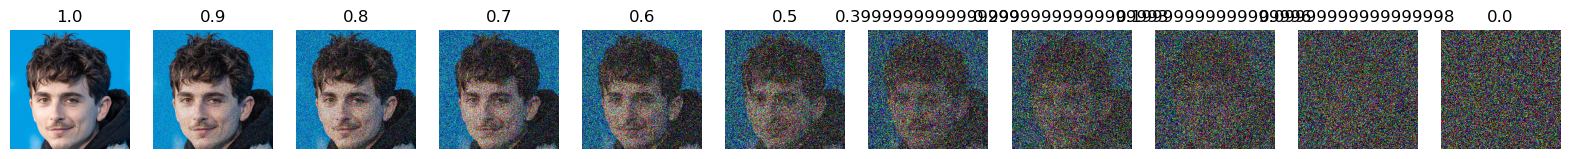

In [4]:
def add_noise(image, alpha, noise_std=30):
    """
    Blend Gaussian noise into the image using alpha blending.
    
    Parameters:
    - image: np.array of shape (H, W, 3), dtype uint8
    - alpha: float between 0 and 1; how much image vs. noise to show
    - noise_std: standard deviation of the Gaussian noise
    
    Returns:
    - np.array of shape (H, W, 3), dtype uint8
    """
    image_float = image.astype(np.float32)
    
    # Generate Gaussian noise centered at 0, with controlled std
    noise = np.random.normal(0, noise_std, image.shape).astype(np.float32)
    
    # Create a noisy version of the image
    noisy_image = np.clip(cv2.addWeighted(image_float, alpha, noise, 1 - alpha, 0), 0, 255)

    return noisy_image.astype(np.uint8)

# Show face with different noise levels as a test
alphas = np.linspace(1.0, 0.0, 11)  # 1 = full face, 0 = full noise
noise_std_level = 200

plt.figure(figsize=(20,5))
for i,a in enumerate(alphas):
    plt.subplot(1,len(alphas), i+1)
    plt.imshow(add_noise(faces_array[0], a, noise_std=noise_std_level))
    plt.axis('off')
    plt.title(a)
plt.show()

In [5]:
# Generate all the images for the experiment
random_trials = []
n_trials_per_condition = 1

for face in faces_array:
    for a in alphas:
        for i in range(n_trials_per_condition):
            img = add_noise(face, a, noise_std=noise_std_level)
            random_trials.append((img, a))

# Shuffle the trials
random.shuffle(random_trials)

# Human's detection of faces in noise

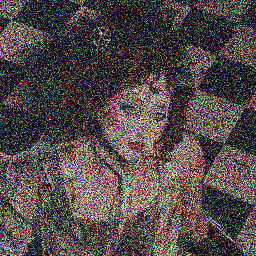

Trial 44/44: Answer slowly. Do you see a face? (y/n):  y


In [6]:
# Run psychophysics task
# Note: if you answer too fast you will accidentally convert your code cell into markdown and need to restart, so answer slowly!
human_results = []
observer_ID = input("Enter your initials: ")
datetime_string = datetime.now().strftime("%Y-%m-%d-%H-%M")

i = 0
for img, alpha in random_trials:
    clear_output(wait=True)
    display(Image.fromarray(img))
    t0 = time.time()
    resp = input(f"Trial {i+1}/{len(random_trials)}: Answer slowly. Do you see a face? (y/n): ").strip().lower()
    rt = time.time() - t0
    human_results.append({"trial": i+1, "alpha": alpha, "response": resp, "RT": rt})
    i += 1

In [7]:
# set up a results table
df = pd.DataFrame(human_results)
results_summary = pd.DataFrame(columns=["alpha", "human_detection_rate", "machine_detection_rate"])
results_summary.set_index('alpha', inplace=True)
results_summary["human_detection_rate"] = df.groupby("alpha")["response"].apply(lambda x: np.mean([r == 'y' for r in x]))
results_summary

,human_detection_rate,machine_detection_rate
alpha,,
0.0,0.0,NaN
0.1,0.0,NaN
0.2,0.0,NaN
0.3,0.5,NaN
0.4,1.0,NaN
0.5,1.0,NaN
0.6,1.0,NaN
0.7,1.0,NaN
0.8,1.0,NaN


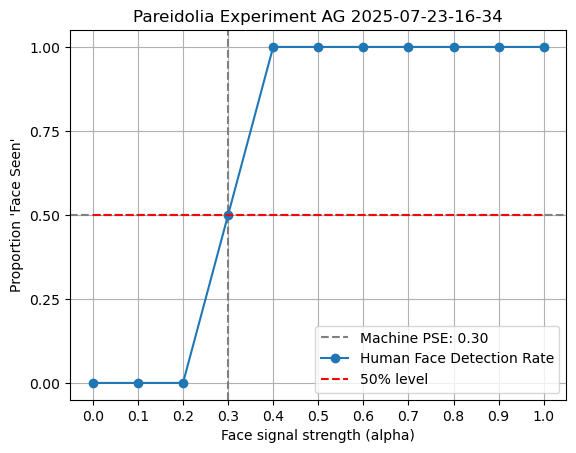

In [13]:
# Analyze & plot human results

# estimate the PSE and JND & plot
fine = np.linspace(results_summary.index.min(), results_summary.index.max(), 200)
interp_props = np.interp(fine, results_summary.index.to_list(), results_summary.human_detection_rate.values)
PSE = np.interp(0.5, interp_props, fine) 
plt.axhline(0.5, color='gray', linestyle='--', label="Machine PSE: {:.2f}".format(PSE))
plt.axvline(PSE, color='gray', linestyle='--')

# plot
results_summary.human_detection_rate.plot(marker='o', label='Human Face Detection Rate')
plt.ylabel("Proportion 'Face Seen'")
plt.xlabel("Face signal strength (alpha)")
plt.title("Pareidolia Experiment " + observer_ID + " " + datetime_string)
plt.plot([0,1],[0.5,0.5],'r--',label='50% level')
plt.xticks(alphas)
plt.yticks([0,0.25,0.5,0.75,1])
plt.grid(True)
plt.legend()
plt.show()

# Machine's detection of faces in noise

In [15]:
# Set up the machine face detector model
proto_url = "https://github.com/opencv/opencv/raw/master/samples/dnn/face_detector/deploy.prototxt"
model_url = "https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel"
proto_path = "deploy.prototxt"
model_path = "res10_300x300_ssd_iter_140000.caffemodel"

# Download the model files if not already present
if not os.path.exists(proto_path):
    urllib.request.urlretrieve(proto_url, proto_path)
if not os.path.exists(model_path):
    urllib.request.urlretrieve(model_url, model_path)

# Load the model
dnn_face_detector = cv2.dnn.readNetFromCaffe(proto_path, model_path)

# Function to detect faces using DNN
def detect_face_dnn(image, confidence_threshold=0.07):
    if image.ndim == 2 or image.shape[2] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104, 177, 123))
    dnn_face_detector.setInput(blob)
    detections = dnn_face_detector.forward()
    return detections[0, 0, :, 2].max() > confidence_threshold

In [16]:
# Run the experiment for machine detection
machine_results = []
for img, alpha in random_trials:
    detected = detect_face_dnn(img, confidence_threshold=0.5)
    machine_results.append((alpha, detected))

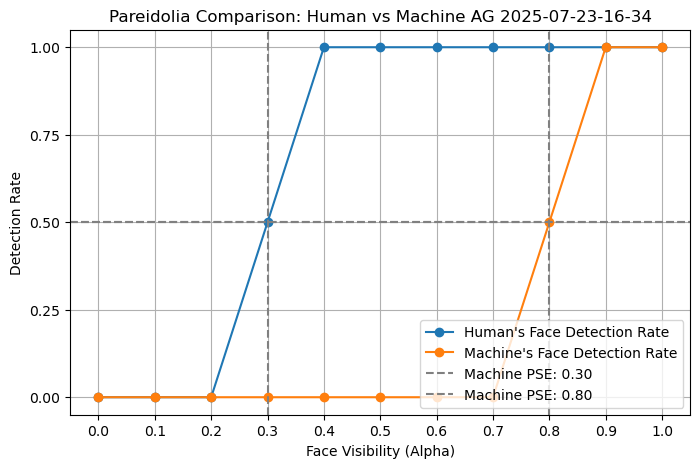

Human PSE is 0.30 which is the value of the noise (alpha) where humans perceive a face ~50% of the time.
Machine PSE is 0.80 which is the value of the noise (alpha) where Caffe's DNN algorithm perceives a face ~50% of the time.
Humans are better than this particular algorithm at detecting a face in noise.
The limitations of this study include: only one observer, only four test faces -- none of which were aligned in terms of position and size, only one type of noise, only one machine face detector.


In [17]:
# Visualize machine detection results curve, with the human curve overlaid

# calculate the percentage of detected faces for each alpha
grouped = defaultdict(list)
for alpha, detected in machine_results:
    grouped[alpha].append(detected)
mean_detect = {a: np.mean(grouped[a]) for a in grouped}
alpha_sorted = sorted(mean_detect.keys())
detections_sorted = [mean_detect[a] for a in alpha_sorted]
results_summary.machine_detection_rate = detections_sorted

# estimate the machine's PSE and JND
fine = np.linspace(min(alpha_sorted), max(alpha_sorted), 200)
interp_props = np.interp(fine, alpha_sorted, detections_sorted)
machine_PSE = np.interp(0.5, interp_props, fine) 

# plot human and machine results
plt.figure(figsize=(8, 5))
results_summary.human_detection_rate.plot(marker='o', label="Human's Face Detection Rate")
results_summary.machine_detection_rate.plot(marker='o', label="Machine's Face Detection Rate")
plt.axhline(0.5, color='gray', linestyle='--', label="Machine PSE: {:.2f}".format(PSE))
plt.axvline(PSE, color='gray', linestyle='--')
plt.axhline(0.5, color='gray', linestyle='--', label="Machine PSE: {:.2f}".format(machine_PSE))
plt.axvline(machine_PSE, color='gray', linestyle='--')
plt.xlabel("Face Visibility (Alpha)")
plt.ylabel("Detection Rate")
plt.title("Pareidolia Comparison: Human vs Machine " + observer_ID + " " + datetime_string)
plt.xticks(alphas)
plt.yticks([0,0.25,0.5,0.75,1])
plt.grid(True)
plt.legend(loc='lower right')
filepath = os.path.join(output_data_path, "lab3.png")
plt.savefig(filepath)
plt.show()

# print conclusions
print("Human PSE is {:.2f} which is the value of the noise (alpha) where humans perceive a face ~50% of the time.".format(PSE))
print("Machine PSE is {:.2f} which is the value of the noise (alpha) where Caffe's DNN algorithm perceives a face ~50% of the time.".format(machine_PSE))
if machine_PSE > PSE:
    print("Humans are better than this particular algorithm at detecting a face in noise.")
elif machine_PSE < PSE:
    print("This particular algorithm is better than humans detecting a face in noise.")
else:
    print("Humans are the same as this particular algorithm at detecting a face in noise.") 
print("The limitations of this study include: only one observer, only four test faces -- none of which were aligned in terms of position and size, only one type of noise, only one machine face detector.")

# Deliverables

If you've made it this far, you should now have an understanding of how to set a very simple paradoilia experiment and compare human and machine performance. 
To complete lab 3: 

Click on the folder icon in the upper left, and navigate to /expt_results/lab3/. 

Select all "lab3.png" and then right click to download it. 

Now upload it to bCourses and answer the questions in the [Lab 3 quiz](https://bcourses.berkeley.edu/courses/1544768/quizzes/2501025). Congrats on finishing lab 3!